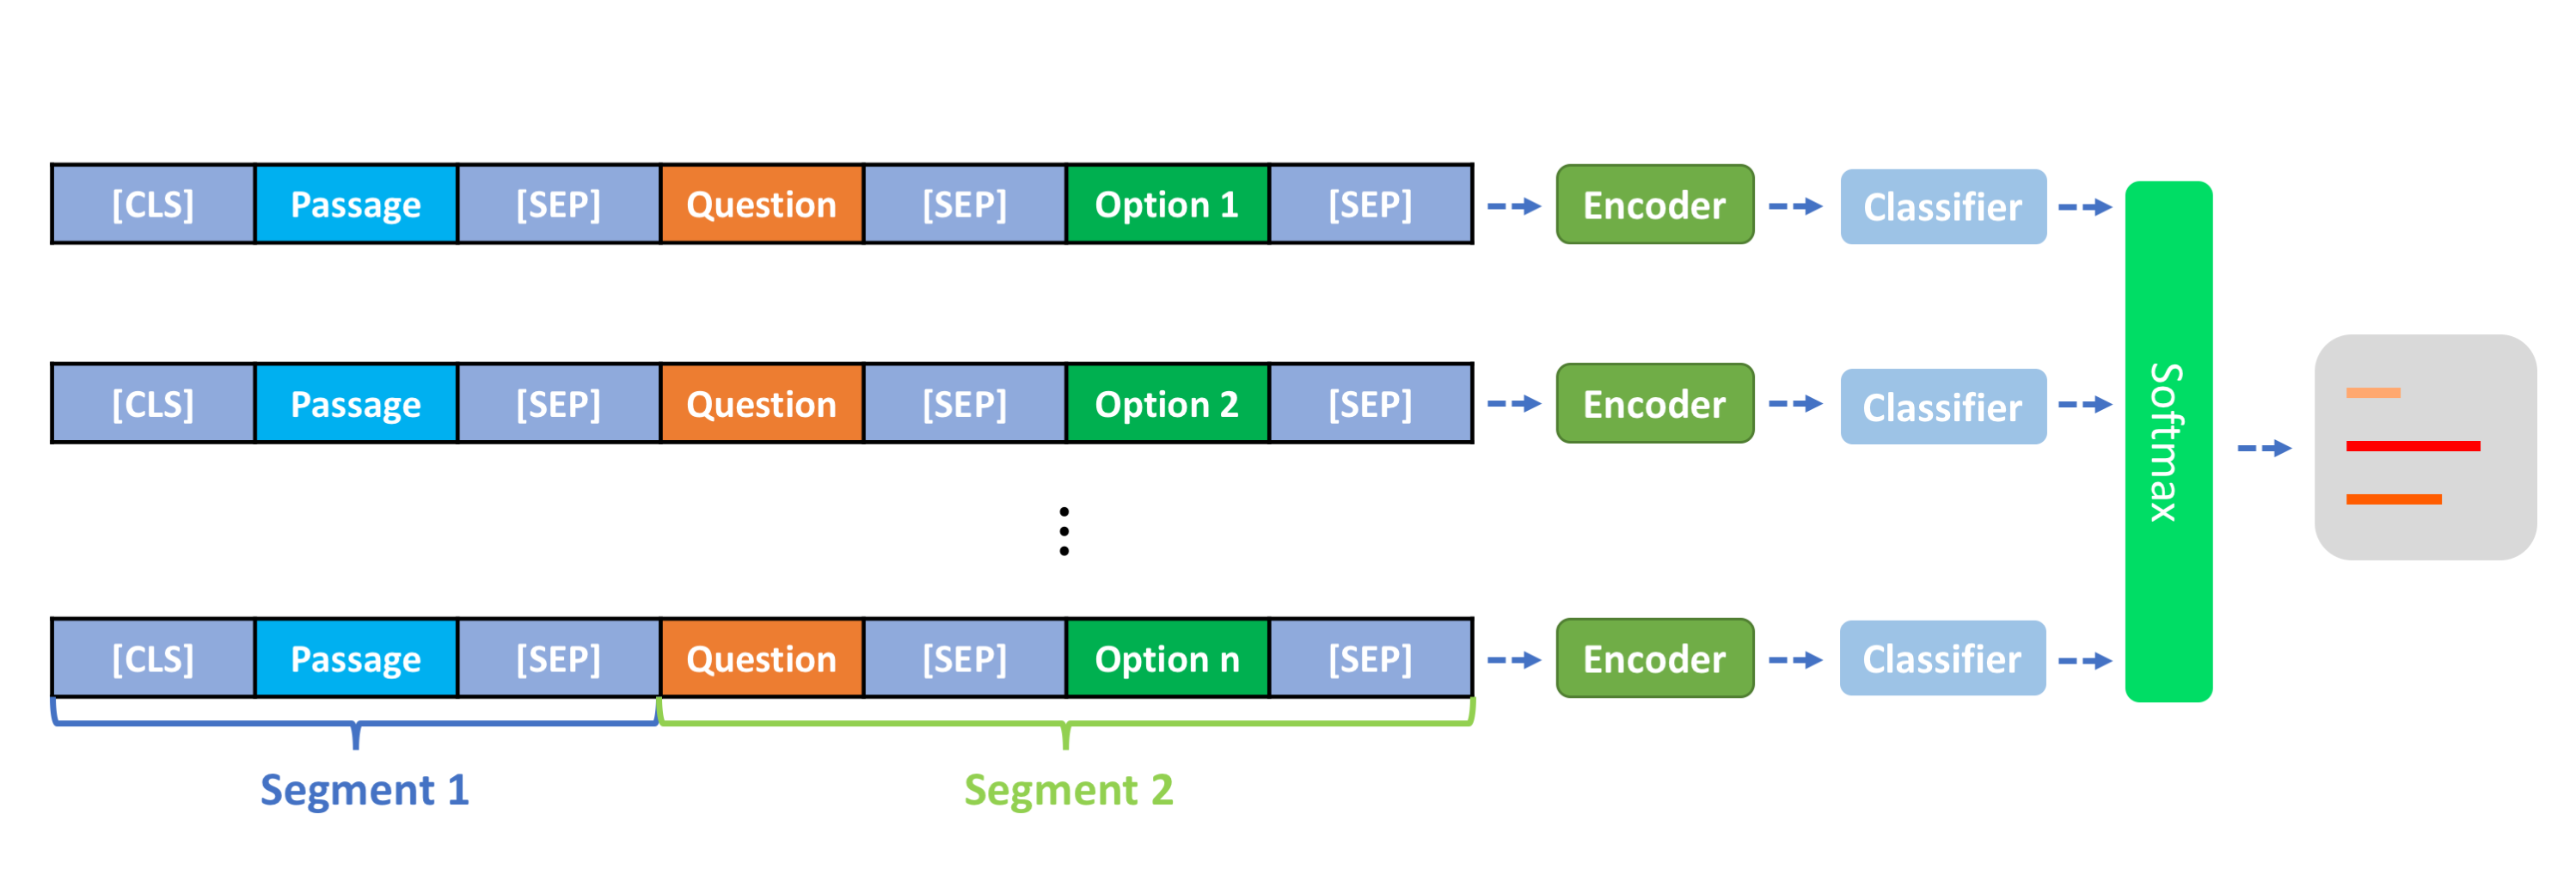

# 加载数据集

In [1]:
!wget https://storage.googleapis.com/cluebenchmark/tasks/c3_public.zip
!unzip c3_public.zip -d c3_public

--2021-07-29 14:46:03--  https://storage.googleapis.com/cluebenchmark/tasks/c3_public.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.206.240, 172.217.161.208, 142.250.76.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.206.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3200727 (3.1M) [application/zip]
Saving to: ‘c3_public.zip’

c3_public.zip       100%[===================>]   3.05M  2.10MB/s    in 1.5s    

2021-07-29 14:46:05 (2.10 MB/s) - ‘c3_public.zip’ saved [3200727/3200727]

Archive:  c3_public.zip
  inflating: c3_public/d-dev.json    
  inflating: c3_public/m-dev.json    
  inflating: c3_public/d-train.json  
  inflating: c3_public/m-train.json  
  inflating: c3_public/test.json     


In [2]:
import codecs
import json
import numpy as np

In [3]:
train = json.load(open('c3_public/d-train.json')) + json.load(open('c3_public/m-train.json'))
val = json.load(open('c3_public/m-dev.json')) + json.load(open('c3_public/d-dev.json'))

In [4]:
train_label = [x[1][0]['choice'].index(x[1][0]['answer']) for x in train]
val_label = [x[1][0]['choice'].index(x[1][0]['answer']) for x in val]

In [7]:
train[0]

[['男：你今天晚上有时间吗?我们一起去看电影吧?', '女：你喜欢恐怖片和爱情片，但是我喜欢喜剧片，科幻片一般。所以……'],
 [{'question': '女的最喜欢哪种电影?',
   'choice': ['恐怖片', '爱情片', '喜剧片', '科幻片'],
   'answer': '喜剧片'}],
 '25-35']

# 处理数据集

In [8]:
import torch
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', num_choices=4)
# train_encoding = tokenizer(list(train_lines), truncation=True, padding=True, max_length=64)
# val_encoding = tokenizer(list(val_lines), truncation=True, padding=True, max_length=64)

In [9]:
def collate_fn(data): #将文章问题选项拼在一起后，得到分词后的数字id，输出的size是(batch, n_choices, max_len)
    input_ids, attention_mask, token_type_ids = [], [], []
    for x in data:
        text = tokenizer(x[1], text_pair=x[0], padding='max_length', truncation=True, 
                         max_length=128, return_tensors='pt')
        input_ids.append(text['input_ids'].tolist())
        attention_mask.append(text['attention_mask'].tolist())
        token_type_ids.append(text['token_type_ids'].tolist())
    input_ids = torch.tensor(input_ids)
    attention_mask = torch.tensor(attention_mask)
    token_type_ids = torch.tensor(token_type_ids)
    label = torch.tensor([x[-1] for x in data])
    return input_ids, attention_mask, token_type_ids, label

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

class TextDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __getitem__(self, idx):
        label = self.labels[idx]
        question = self.data[idx][1][0]['question']
        content = '。'.join(self.data[idx][0])
        choice = self.data[idx][1][0]['choice']
        if len(choice) < 4: #如果选项不满四个，就补“不知道”
            for i in range(4-len(choice)):
                choice.append('不知道')
        
        content = [content for i in range(len(choice))]
        pair = [question + ' ' + i for i in choice]
        
        return content, pair, label
    
    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train, train_label)
test_dataset = TextDataset(val, val_label)

In [22]:
train_dataset[0]

(['男：你今天晚上有时间吗?我们一起去看电影吧?。女：你喜欢恐怖片和爱情片，但是我喜欢喜剧片，科幻片一般。所以……',
  '男：你今天晚上有时间吗?我们一起去看电影吧?。女：你喜欢恐怖片和爱情片，但是我喜欢喜剧片，科幻片一般。所以……',
  '男：你今天晚上有时间吗?我们一起去看电影吧?。女：你喜欢恐怖片和爱情片，但是我喜欢喜剧片，科幻片一般。所以……',
  '男：你今天晚上有时间吗?我们一起去看电影吧?。女：你喜欢恐怖片和爱情片，但是我喜欢喜剧片，科幻片一般。所以……'],
 ['女的最喜欢哪种电影? 恐怖片', '女的最喜欢哪种电影? 爱情片', '女的最喜欢哪种电影? 喜剧片', '女的最喜欢哪种电影? 科幻片'],
 2)

# 模型训练

In [12]:
import torch
from transformers import BertForMultipleChoice, AdamW, get_linear_schedule_with_warmup
model = BertForMultipleChoice.from_pretrained('bert-base-chinese')

# device = 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMultipleChoice: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-chinese and are newly

BertForMultipleChoice(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

optim = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * 1
scheduler = get_linear_schedule_with_warmup(optim, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [19]:
for i in train_loader:
    print(i) # 32 batch_size,input_ids,token_type_ids,attention_masks,label
    break

(tensor([[[ 101, 4511, 4638,  ...,    0,    0,    0],
         [ 101, 4511, 4638,  ...,    0,    0,    0],
         [ 101, 4511, 4638,  ...,    0,    0,    0],
         [ 101, 4511, 4638,  ...,    0,    0,    0]],

        [[ 101, 1957, 4638,  ...,    0,    0,    0],
         [ 101, 1957, 4638,  ...,    0,    0,    0],
         [ 101, 1957, 4638,  ...,    0,    0,    0],
         [ 101, 1957, 4638,  ...,    0,    0,    0]],

        [[ 101,  800,  812,  ...,  136,  671,  102],
         [ 101,  800,  812,  ..., 1450,  136,  102],
         [ 101,  800,  812,  ..., 3416, 6432,  102],
         [ 101,  800,  812,  ..., 3416, 6432,  102]],

        ...,

        [[ 101, 6432, 6413,  ..., 6206, 1914,  102],
         [ 101, 6432, 6413,  ..., 6206, 1914,  102],
         [ 101, 6432, 6413,  ..., 6206, 1914,  102],
         [ 101, 6432, 6413,  ..., 6206, 1914,  102]],

        [[ 101, 4511, 4638,  ...,    0,    0,    0],
         [ 101, 4511, 4638,  ...,    0,    0,    0],
         [ 101, 4511, 4

In [20]:
from tqdm import tqdm

def train():
    model.train()
    total_train_loss = 0
    iter_num = 0
    total_iter = len(train_loader)
    for idx, (input_ids, attention_mask, token_type_ids, labels) in enumerate(train_loader):
        optim.zero_grad()
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        # print(labels)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            # loss = outputs[0]

        # print(outputs[1])
        loss = outputs.loss
        
        if idx % 20 == 0:
            with torch.no_grad():
                # 64 * 7
                print((outputs[1].argmax(1).data == labels.data).float().mean().item(), loss.item())
        
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step()
        scheduler.step()

        iter_num += 1
        if(iter_num % 100 ==0):
            print("epoth: %d, iter_num: %d, loss: %.4f, %.2f%%" % (epoch, iter_num, loss.item(), iter_num/total_iter*100))
        
    print("Epoch: %d, Average training loss: %.4f"%(epoch, total_train_loss/len(train_loader)))
    
def validation():
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    for (input_ids, attention_mask, token_type_ids, labels) in test_dataloader:
        with torch.no_grad():
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs[1]

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        total_eval_accuracy += (outputs[1].argmax(1).data == labels.data).float().mean().item()
        
    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    print("Accuracy: %.4f" % (avg_val_accuracy))
    print("Average testing loss: %.4f"%(total_eval_loss/len(test_dataloader)))
    print("-------------------------------")
    

for epoch in range(4):
    print("------------Epoch: %d ----------------" % epoch)
    validation()
    train()
    

------------Epoch: 0 ----------------
Accuracy: 0.2290
Average testing loss: 1.3891
-------------------------------
0.3125 1.3743128776550293
0.375 1.3406208753585815
0.4375 1.1734873056411743
0.5 1.1664682626724243
0.4375 1.1482946872711182
epoth: 0, iter_num: 100, loss: 1.0873, 39.84%
0.5625 0.987983226776123
0.4375 1.045220971107483
0.53125 1.1226638555526733
0.625 0.9524713158607483
0.65625 1.026518702507019
epoth: 0, iter_num: 200, loss: 0.9274, 79.68%
0.65625 0.8287029266357422
0.5625 1.0176482200622559
0.71875 0.8734238147735596
Epoch: 0, Average training loss: 1.1197
------------Epoch: 1 ----------------
Accuracy: 0.5478
Average testing loss: 1.0204
-------------------------------
0.59375 0.8776536583900452
0.53125 0.9147205948829651
0.53125 0.9855321645736694
0.59375 0.9277408719062805
0.59375 0.9268087148666382
epoth: 1, iter_num: 100, loss: 0.7252, 39.84%
0.59375 0.9283379912376404
0.5 1.0375932455062866
0.5625 0.9482977390289307
0.59375 0.8870478868484497
0.65625 0.93417984

# 模型预测

In [36]:
for (input_ids, attention_mask, token_type_ids, labels) in test_dataloader:
    input_ids, attention_mask, token_type_ids, labels = input_ids[:1], attention_mask[:1], token_type_ids[:1], labels[:1]
    with torch.no_grad():
        input_ids = input_ids.to(device)
        print("input_ids:\n",input_ids)
        for i in range(4):
            print("decode question-choice-context:\n",tokenizer.decode(input_ids[0][i]))
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        print("labels:\n",labels)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    logits = outputs[1]

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()
    print("predict label:\n",outputs[1].argmax(1).data)
    break

input_ids:
 tensor([[[ 101, 4511, 4638, 1762, 2823,  784,  720,  136,  741, 1259,  102,
          4511, 8038, 1968, 8024,  872, 4692, 1168, 2769, 4638, 7192, 5011,
           749, 1408,  136,  511, 1957, 8038,  679, 1762,  741, 1259, 7027,
          1408,  136,  511, 4511, 8038,  679, 1762, 8024, 2769, 6381, 2533,
          3219, 1921, 1091,  868,  689, 4638, 3198,  952, 6820, 4500, 1450,
           511,  511, 1957, 8038,  872, 4692, 8024, 1762, 2099, 1073, 3178,
          6804, 1450,  511,  102,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0],
         [ 101, 4511, 4638, 1762, 2823,  784,  720,  136, 7192, 5011,  102,
          4511, 8038, 1